In [1]:
import os
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
# From PDFInterpreter import both PDFResourceManager and PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
# Import this to raise exception whenever text extraction from PDF is not allowed
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.layout import LAParams, LTTextBox, LTTextLine
from pdfminer.converter import PDFPageAggregator

import re

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda3\envs\CloudLab-27\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
''' This is what we are trying to do:
1) Transfer information from PDF file to PDF document object. This is done using parser
2) Get a list of PDF files (papers) from the Papers directory
3) For each PDF file, open and parse the file using PDFParser object
4) Assign the parsed content to PDFDocument object
5) Now the information in this PDFDocumet object has to be processed. For this we need
   PDFPageInterpreter, PDFDevice and PDFResourceManager
6) Finally process the file page by page 
'''

base_path = "C:\Users\Linh B Ngo\Google Drive\CloudLab2\Papers"
 
my_files = [f for f in os.listdir(base_path)]

# depending on operating system, you might have to modify this code to remove system files
my_files.remove('desktop.ini')
print (my_files)

['Active Learning in Performance Analysis.pdf', 'An information infrastructure framework for smart grids leveraging SDN and cloud.pdf', 'ARM Virtualization Performance and Architectural Implications.pdf', 'Brados Declarative Programmable Object Storage.pdf', 'CQSTR - Securing Cross\xacTenant Applications with Cloud Containers.pdf', 'High-Performance ACID via Modular Concurrency Control.pdf', 'JetStream ClusterScale Parallelization of Information Flow Queries.pdf', 'One Bit Flips One Cloud Flops Cross VM Row Hammer Attacks and Privilege Escalation.pdf', 'Paving the Way for NFV Simplifying Middlebox Modifications using StateAlyzr.pdf', 'Reproducible Scientific Computing Environment with Overlay Cloud Architecture - IEEE Conference Publication.pdf', 'SEINA - A Stealthy and Effective Internal Attack in Hadoop Systems.pdf', 'Self-configuring Software-defined Overlay Bypass for Seamless Inter and Intra-cloud Virtual Networking.pdf', 'Split-level IO scheduling.pdf', 'Subways - A Case for Redu

In [3]:
papers = []
papers_title = []

for f in my_files:
    password = ""
    extracted_text = ""    
    papers_title.append(f.split('.pdf', 1)[0].replace(' ','_'))
    
    print(f)
    fp = open(os.path.join(base_path, f), "rb")    
    parser = PDFParser(fp)    
    document = PDFDocument(parser, password)
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed    
    rsrcmgr = PDFResourceManager()
    laparams = LAParams()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # Ok now that we have everything to process a pdf document, lets process it page by page
    for page in PDFPage.create_pages(document):
        # As the interpreter processes the page stored in PDFDocument object
        interpreter.process_page(page)
        # The device renders the layout from interpreter
        layout = device.get_result()
        # Out of the many LT objects within layout, we are interested in LTTextBox and LTTextLine
        for lt_obj in layout:
            if isinstance(lt_obj, LTTextBox) or isinstance(lt_obj, LTTextLine):
                extracted_text += lt_obj.get_text()
    fp.close()
    
    # Some preliminary data cleaning
    extracted_text = extracted_text.lower()
    headless_text = extracted_text.split("abstract", 1)[1].split('introduction', 1)[1]
    final_text = headless_text.rsplit('references', 1)[0].replace('-\n','').replace('\n', ' ').replace(ur'\u201c', ' ').replace(ur'\u201d', ' ').replace(ur'\ufb01', 'fi').replace(ur'\u2022', ' ').replace(ur'\u2013', ' ')
    
    papers.append(final_text)

Active Learning in Performance Analysis.pdf
An information infrastructure framework for smart grids leveraging SDN and cloud.pdf
ARM Virtualization Performance and Architectural Implications.pdf
Brados Declarative Programmable Object Storage.pdf
CQSTR - Securing Cross�Tenant Applications with Cloud Containers.pdf
High-Performance ACID via Modular Concurrency Control.pdf
JetStream ClusterScale Parallelization of Information Flow Queries.pdf
One Bit Flips One Cloud Flops Cross VM Row Hammer Attacks and Privilege Escalation.pdf
Paving the Way for NFV Simplifying Middlebox Modifications using StateAlyzr.pdf
Reproducible Scientific Computing Environment with Overlay Cloud Architecture - IEEE Conference Publication.pdf
SEINA - A Stealthy and Effective Internal Attack in Hadoop Systems.pdf
Self-configuring Software-defined Overlay Bypass for Seamless Inter and Intra-cloud Virtual Networking.pdf
Split-level IO scheduling.pdf
Subways - A Case for Redundant, Inexpensive Data Center Edge Links.pd

In [4]:
STOPWORDS = stopwords.words('english')
COMMONWORDS = ['cid:31','figure','two','cid:27', \
               'cid:29','also','cid:28','cid:30', \
               'cid:25','cid:26','performance','data', \
               'cid:24','cid:21','cid:22','cid:23', 'cid:20']

def clean_text(text):    
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if \
                        t not in STOPWORDS and \
                        t not in COMMONWORDS and \
                        re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text
 
# For gensim we need to tokenize the data and filter out stopwords
tokenized_data = []
for text in papers:
    tokenized_data.append(clean_text(text)) 

# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Form Bigrams
data_words_bigrams = make_bigrams(tokenized_data)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Anaconda3\envs\CloudLab-27\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


To evaluate the optimal number of topics, we run a comprehensive check over a range of numbers, and compare resulting coherence score [1]
and perplexity. 


[1] Lau, J. H., Newman, D., & Baldwin, T. (2014). Machine reading tea leaves: Automatically evaluating topic coherence and topic model quality. In Proceedings of the 14th Conference of the European Chapter of the Association for Computational Linguistics (pp. 530-539).

In [5]:
MAX_NUM_TOPICS = 30
coherence_values = []
for idx in range(2,MAX_NUM_TOPICS):
    print('\nNumber of topics: ', idx)
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=idx, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=200,
                                               alpha='auto',
                                               per_word_topics=True)

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    coherence_values.append(coherence_lda)

('\nNumber of topics: ', 2)
('\nPerplexity: ', -7.4846446067835)
('\nCoherence Score: ', 0.22027123083565736)
('\nNumber of topics: ', 3)
('\nPerplexity: ', -7.403899121565936)
('\nCoherence Score: ', 0.259785642620546)
('\nNumber of topics: ', 4)
('\nPerplexity: ', -7.3181802974882615)
('\nCoherence Score: ', 0.3463486351883946)
('\nNumber of topics: ', 5)
('\nPerplexity: ', -7.287672665079577)
('\nCoherence Score: ', 0.3341297595401808)
('\nNumber of topics: ', 6)
('\nPerplexity: ', -7.231193237073788)
('\nCoherence Score: ', 0.34381143673204345)
('\nNumber of topics: ', 7)
('\nPerplexity: ', -7.185268659252924)
('\nCoherence Score: ', 0.42354973961983683)
('\nNumber of topics: ', 8)
('\nPerplexity: ', -7.169662035825476)
('\nCoherence Score: ', 0.5254391024300449)
('\nNumber of topics: ', 9)
('\nPerplexity: ', -7.138765011088512)
('\nCoherence Score: ', 0.4477784170833512)
('\nNumber of topics: ', 10)
('\nPerplexity: ', -7.148086223720707)
('\nCoherence Score: ', 0.49753630527458503

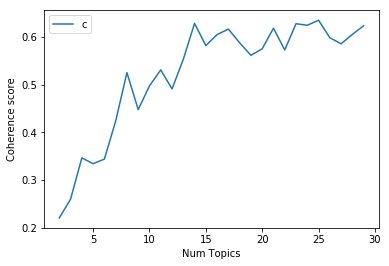

In [6]:
# Show graph
plt.plot(range(2, MAX_NUM_TOPICS), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()